In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Loading the data

In [2]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    true_path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/True.csv'
    fake_path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/Fake.csv'
    true_df = pd.read_csv(true_path, nrows=nrows)
    fake_df = pd.read_csv(fake_path, nrows=nrows)
    return true_df, fake_df

In [3]:
true, fake = get_data_from_gcp(nrows=None)

print('-'*80)
print(f"true shape: {true.shape}")
print(f"fake shape: {fake.shape}")
print('-'*80)

--------------------------------------------------------------------------------
true shape: (21417, 4)
fake shape: (23481, 4)
--------------------------------------------------------------------------------


## Duplicates

In [4]:
def count_duplicate(df):
    return df.duplicated().sum()

In [5]:
print('-'*80)
print(f"true duplicates: {count_duplicate(true)}")
print(f"fake duplicates: {count_duplicate(fake)}")
print('-'*80)

--------------------------------------------------------------------------------
true duplicates: 206
fake duplicates: 3
--------------------------------------------------------------------------------


In [6]:
true.drop_duplicates(inplace=True)
fake.drop_duplicates(inplace=True)

print('-'*80)
print(f"true shape (wo duplicates): {true.shape}")
print(f"fake shape (wo duplicates): {fake.shape}")
print('-'*80)

--------------------------------------------------------------------------------
true shape (wo duplicates): (21211, 4)
fake shape (wo duplicates): (23478, 4)
--------------------------------------------------------------------------------


## Create Labels and Merge `true`/`fake` datasets

In [7]:
true['category'] = 0
fake['category'] = 1

data = pd.concat([true, fake]).reset_index(drop=True)

print('-'*80)
print(f"data shape: {data.shape}")
print('-'*80)
print(f"ratio #true: {len(data[data['category']==0])/len(data)*100:.2f}%")
print(f"ratio #fake: {len(data[data['category']==1])/len(data)*100:.2f}%")
print('-'*80)

--------------------------------------------------------------------------------
data shape: (44689, 5)
--------------------------------------------------------------------------------
ratio #true: 47.46%
ratio #fake: 52.54%
--------------------------------------------------------------------------------


In [9]:
data.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0


In [12]:
# def drop_prefix(text,prefix='(Reuters)',n=5):
#     ts = str.split(text,' ')
#     if prefix in ts[:n]:
#         return str.split(text,prefix)[-1]
#     else:
#         return text

4659

In [10]:
data[data['text'].str.contains("reuters")]

,title,text,subject,date,category
679,"As Trump targets immigrants, U.S. farm sector ...",LOS ANGELES (Reuters) - Convincing big U.S. d...,politicsNews,"November 10, 2017",0
850,New Trump immigration efforts aim to stop chil...,NEW YORK (Reuters) - Many of the immigration i...,politicsNews,"November 3, 2017",0
882,Trump's opponents race to the courthouse to th...,WASHINGTON (Reuters) - When President Donald ...,politicsNews,"November 2, 2017",0
1373,Help wanted: Staff shortages under Trump slow ...,WASHINGTON (Reuters) - Hundreds of government ...,politicsNews,"October 6, 2017",0
1416,Obamacare sign-up challenge: proving the law i...,"NOGALES, Arizona (Reuters) - More than two th...",politicsNews,"October 4, 2017",0
1418,Whirlpool's washer war is balancing act for Trump,"Clyde, Ohio (Reuters) - In the middle of Whir...",politicsNews,"October 4, 2017",0
1465,U.S. visas to six Muslim nations drop after Su...,WASHINGTON (Reuters) - In the first two month...,politicsNews,"September 29, 2017",0
5034,Industry questions higher insurance costs unde...,NEW YORK (Reuters) - The House Republican heal...,politicsNews,"March 7, 2017",0
7485,"Fending off foes, Clinton blazes a trail with ...",WASHINGTON (Reuters) - Hillary Clinton has one...,politicsNews,"November 6, 2016",0
8548,The year of 'Neither': Why Reuters/Ipsos is tw...,NEW YORK (Reuters) - In a presidential campaig...,politicsNews,"July 29, 2016",0


## Missing values

In [ ]:
def get_missing(df):
    missing_values = df.isnull().sum().sort_values(ascending = False)
    ratio = missing_values/len(data)*100
    return pd.DataFrame({'missing_values': missing_values, 'ratio': round(ratio)}).head(10)

get_missing(data)

,missing_values,ratio
category,0,0.0
date,0,0.0
subject,0,0.0
text,0,0.0
title,0,0.0


## Preprocessing

In [ ]:
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

# Required only for Colab
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean(text):
    """
    Provided by Le Wagon - Machine Learning - NLP
    Preprocessing articles - punctuation / lowercased / tokenize / stop_words / lemmatize
    """
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
    lowercased = text.lower() # Lower Case
    tokenized = word_tokenize(lowercased) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    stop_words = set(stopwords.words('english')) # Make stopword list
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    lemma = WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    return lemmatized

data['clean_text'] = data['text'].apply(clean)
data['clean_title'] = data['title'].apply(clean)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
data.head()

,title,text,subject,date,category,clean_text,clean_title
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",0,"[washington, reuters, head, conservative, repu...","[u, budget, fight, loom, republican, flip, fis..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",0,"[washington, reuters, transgender, people, all...","[u, military, accept, transgender, recruit, mo..."
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",0,"[washington, reuters, special, counsel, invest...","[senior, u, republican, senator, let, mr, muel..."
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",0,"[washington, reuters, trump, campaign, adviser...","[fbi, russia, probe, helped, australian, diplo..."
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",0,"[seattle, washington, reuters, president, dona...","[trump, want, postal, service, charge, much, a..."


## Training

In [ ]:
X_text = data['clean_text'].copy()
X_title = data['clean_title'].copy()
y = data['category'].copy()

print('-'*80)
print(f"X_text shape: {X_text.shape}")
print(f"X_title shape: {X_title.shape}")
print(f"y shape: {y.shape}")
print('-'*80)

--------------------------------------------------------------------------------
X_text shape: (44689,)
X_title shape: (44689,)
y shape: (44689,)
--------------------------------------------------------------------------------


In [ ]:
from sklearn.model_selection import train_test_split

X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, test_size=0.3, random_state=42)
X_title_train, X_title_test, y_train, y_test = train_test_split(X_title, y, test_size=0.3, random_state=42)

print('-'*80)
print(f"X_text_train shape: {X_text_train.shape}")
print(f"X_title_train shape: {X_title_train.shape}")
print(f"y_train shape: {y_train.shape}")
print('-'*80)
print(f"X_text_test shape: {X_text_test.shape}")
print(f"X_title_test shape: {X_title_test.shape}")
print(f"y_test shape: {y_test.shape}")
print('-'*80)

--------------------------------------------------------------------------------
X_text_train shape: (31282,)
X_title_train shape: (31282,)
y_train shape: (31282,)
--------------------------------------------------------------------------------
X_text_test shape: (13407,)
X_title_test shape: (13407,)
y_test shape: (13407,)
--------------------------------------------------------------------------------


In [ ]:
hparams = {
    "batch_size": 128,
    "cnn_filter_sizes": [128, 128, 128],
    "cnn_kernel_sizes": [5, 5, 5],
    "cnn_pooling_sizes": [5, 5, 40],
    "constraint_learning_rate": 0.01,
    "embedding_dim": 100,
    "embedding_trainable": False,
    "learning_rate": 0.005,
    "max_num_words": 10000,
    "max_sequence_length": 250
}

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = hparams["max_num_words"])
tokenizer.fit_on_texts(X_text_train)

def prep_text(texts, tokenizer, max_sequence_length):
    # Turns text into into padded sequences.
    text_sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(text_sequences, maxlen = max_sequence_length, padding='post')

X_text_train_pad = prep_text(X_text_train, tokenizer, hparams["max_sequence_length"])
X_text_test_pad = prep_text(X_text_test, tokenizer, hparams["max_sequence_length"])

X_title_train_pad = prep_text(X_title_train, tokenizer, hparams["max_sequence_length"])
X_title_test_pad = prep_text(X_title_test, tokenizer, hparams["max_sequence_length"])

print('-'*80)
print(f"X_text_train_pad shape: {X_text_train_pad.shape}")
print(f"X_text_test_pad shape: {X_text_test_pad.shape}")
print('-'*80)
print(f"X_title_train_pad shape: {X_title_train_pad.shape}")
print(f"X_title_test_pad shape: {X_title_test_pad.shape}")
print('-'*80)

text_vocab_size = len(tokenizer.word_index)
print(f"text vocab_size: {text_vocab_size}")
print('-'*80)

--------------------------------------------------------------------------------
X_text_train_pad shape: (31282, 250)
X_text_test_pad shape: (13407, 250)
--------------------------------------------------------------------------------
X_title_train_pad shape: (31282, 250)
X_title_test_pad shape: (13407, 250)
--------------------------------------------------------------------------------
text vocab_size: 84557
--------------------------------------------------------------------------------


In [ ]:
X_text_test_pad

array([[1271,   14,  799, ...,    0,    0,    0],
       [ 961,  340,  264, ..., 1333,   82, 4877],
       [  11,  450, 1256, ...,    0,    0,    0],
       ...,
       [ 364, 1016,   34, ...,    0,    0,    0],
       [1045, 2096,  191, ...,    0,    0,    0],
       [  50,  194,  491, ...,  114, 2675,  393]], dtype=int32)

## Model

In [ ]:
import io
import urllib
import zipfile

# Pre-trained GloVe word vector embeddings
zip_file_url = "http://nlp.stanford.edu/data/glove.6B.zip"
zip_file = urllib.request.urlopen(zip_file_url)
archive = zipfile.ZipFile(io.BytesIO(zip_file.read()))

In [ ]:
embeddings_index = {}
glove_file = "glove.6B.100d.txt"

with archive.open(glove_file) as f:
    for line in f:
        values = line.split()
        word = values[0].decode("utf-8") 
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, hparams["embedding_dim"]))
num_words_in_embedding = 0
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        num_words_in_embedding += 1
        embedding_matrix[i] = embedding_vector

print('-'*80)
print(f"embedding_matrix shape: {embedding_matrix.shape}")
print('-'*80)

--------------------------------------------------------------------------------
embedding_matrix shape: (84558, 100)
--------------------------------------------------------------------------------


In [ ]:
def init_model():
    model = tf.keras.models.Sequential()

    # Embedding layer.
    embedding_layer = tf.keras.layers.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length = hparams["max_sequence_length"],
        trainable = hparams['embedding_trainable'],
        mask_zero = True)
    model.add(embedding_layer)

    # Convolution layers.
    for filter_size, kernel_size, pool_size in zip(
        hparams['cnn_filter_sizes'], hparams['cnn_kernel_sizes'],
        hparams['cnn_pooling_sizes']):

        conv_layer = tf.keras.layers.Conv1D(
            filter_size, kernel_size, activation='relu', padding='same')
        model.add(conv_layer)

        pooled_layer = tf.keras.layers.MaxPooling1D(pool_size, padding='same')
        model.add(pooled_layer)

    # Add a flatten layer, a fully-connected layer and an output layer.
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=hparams["learning_rate"])
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model

In [ ]:
init_model().summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 250, 100)          8455800   
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 250, 128)          64128     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 50, 128)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 50, 128)           82048     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 10, 128)           0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 10, 128)           82048     
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 1, 128)           

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

model = init_model()

history = model.fit(X_text_train_pad, 
                  y_train,
                  validation_split=0.2,
                  batch_size=hparams["batch_size"],
                  epochs=10, 
                  callbacks=[es],
                  verbose=1)

Epoch 1/10
196/196 [==============================] - 9s 11ms/step - loss: 0.1888 - accuracy: 0.9238 - val_loss: 0.0485 - val_accuracy: 0.9859
Epoch 2/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0377 - accuracy: 0.9876 - val_loss: 0.0300 - val_accuracy: 0.9914
Epoch 3/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0200 - accuracy: 0.9929 - val_loss: 0.0305 - val_accuracy: 0.9914
Epoch 4/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0137 - accuracy: 0.9957 - val_loss: 0.0318 - val_accuracy: 0.9915
Epoch 5/10
196/196 [==============================] - 2s 10ms/step - loss: 0.0072 - accuracy: 0.9981 - val_loss: 0.0436 - val_accuracy: 0.9925
Epoch 6/10
196/196 [==============================] - 2s 9ms/step - loss: 0.0061 - accuracy: 0.9984 - val_loss: 0.0675 - val_accuracy: 0.9922


In [ ]:
def plot_loss(history, title=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=1)
    ax1.legend(['Train', 'Validation'], loc='best')

    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('ACC')
    ax2.set_ylabel('ACC')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=1)
    ax2.legend(['Train', 'Validation'], loc='best')
    if title:
        fig.suptitle(title)
    plt.show()

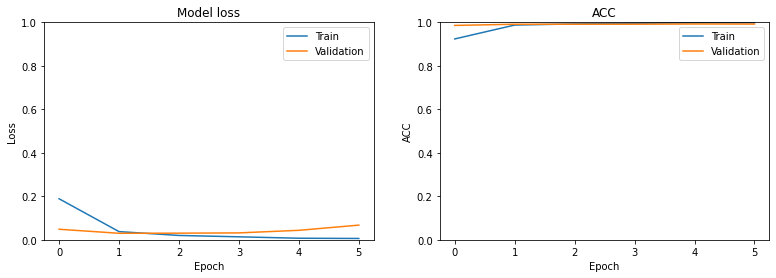

In [ ]:
plot_loss(history, title=None)

In [ ]:
results = model.evaluate(X_text_test_pad, y_test)

print('-'*80)
print(f"test score (ACC): {results[1]:.3f}")
print('-'*80)

419/419 [==============================] - 1s 4ms/step - loss: 0.0252 - accuracy: 0.9917
--------------------------------------------------------------------------------
test score (ACC): 0.992
--------------------------------------------------------------------------------


--------------------------------------------------------------------------------
acc: 99.17%
recall: 98.98%
precision: 99.42%
f1: 99.20%
--------------------------------------------------------------------------------


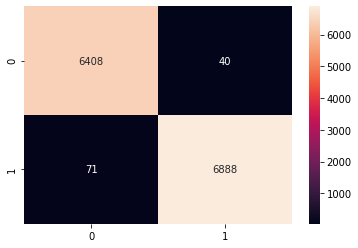

In [ ]:
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

def get_metrics(y_true, X, model):

    y_prob = model.predict(X)
    y_pred = np.where(y_prob > 0.5, 1, 0)

    conf_matrix = confusion_matrix(y_test, y_pred)

    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('-'*80)
    print(f"acc: {acc*100:.2f}%")
    print(f"recall: {recall*100:.2f}%")
    print(f"precision: {precision*100:.2f}%")
    print(f"f1: {f1*100:.2f}%")
    print('-'*80)

    sns.heatmap(conf_matrix, annot=True, fmt="d");

get_metrics(y_test, X_text_test_pad, model)

## Prediction

In [ ]:
# From Straits Times
X_sample = "The parade and ceremony segment will feature the popular fighter jet aerial \
        displays and the landing of Red Lions parachutists, while the show segment will \
        focus on the Singapore Spirit in a display of the country's identity, resilience and can-do attitude."

In [ ]:
fake1 = """
Americans to fund killing babies in abortion that she has been caught trying to add taxpayer financing of abortions to the bill to combat the Coronavirus and provide economic stimulus to the nation as it deals with the COVD-19 outbreak.
Nancy Pelosi has a long history of promoting abortion and her first act after becoming Speaker in 2019 was pushing legislation to use tax money for abortions. So it’s no surprise she is trying to exploit the Coronavirus pandemic to push abortion funding again.
As The Daily Caller reports: House Speaker Nancy Pelosi sought to include a potential way to guarantee federal funding for abortion into the coronavirus economic stimulus plan, according to multiple senior White House officials.
Speaking to the Daily Caller, those officials alleged that while negotiating the stimulus with U.S. Treasury Secretary Steve Mnuchin, Pelosi tried to lobby for “several” provisions that stalled bipartisan commitment to the effort. One was a mandate for up to $1 billion to reimburse laboratory claims, which White House officials say would set a precedent of health spending without protections outlined in the Hyde Amendment.
LifeNews depends on the support of readers like you to combat the pro-abortion media. Please donate now.
“A New mandatory funding stream that does not have Hyde protections would be unprecedented,” one White House official explained. “Under the guise of protecting people, Speaker Pelosi is working to make sure taxpayer dollars are spent covering abortion—which is not only backwards, but goes against historical norms.”
A second White House official referred to the provision as a “slush fund” and yet another questioned “what the Hyde Amendment and abortion have to do with protecting Americans from coronavirus?”
Americans should insist to their members of Congress that we need a clean bill that provides aggressive action to help patients and spur the economy. Killing babies with our tax dollars is not the answer to the coronavirus and the situation should not be exploited for political gain.
"""

fake2 = """
A man calling himself the "vaccine police" posted a video on Facebook making unsubstantiated claims about COVID-19 vaccines and the people administering them at a Walmart pharmacy in Missouri.

The video uploaded on Aug. 16 runs for more than 30 minutes and initially shows a man, identified as Christopher Key, driving up to a Walmart parking lot and filming himself inside his car.

"We are headed to Walmart, and we are going to present documents to the pharmacist, letting them know what they are doing is crimes against humanity and what they are doing is a violation of the Nuremberg Code, and if they do not stand down immediately, then they could be executed," he says.

Later in the video, the man is joined by a few other supporters who join in filming themselves as they walk through the store and up to the pharmacy area, where employees are shuttering the service windows. The video shows Key confronting and threatening other Walmart employees. At some point, Key claims that he’s there to be vaccinated. Eventually, Key and his supporters leave the store, and police await them outside. No one appears to be arrested.

The Washington Post reported that Key "has a history of making discredited medical claims."

Key’s Facebook post was flagged as part of Facebook’s efforts to combat false news and misinformation on its News Feed. (Read more about our partnership with Facebook.)

Key’s claim that pharmacists administering COVID-19 vaccines are doing so in "violation of the Nuremberg Code" is false.

Nuremberg principles
The Nuremberg principles that Key alludes to are not part of U.S. law; they refer to a treaty agreed to after World War II to prosecute individuals for war crimes, and crimes against humanity, said Mary Ellen O’Connell, a law professor at the University of Notre Dame School of Law. One of the principles is that humans should not be subject to medical experiments without their voluntary consent.

O’Connell said that some individuals were charged under the charter with carrying out forced medical experimentation, and such forced experimentation is barred specifically in current treaties on the law of armed conflict, most notably the Geneva Conventions of 1949 and the Additional Protocols of 1977.

Key’s argument is based on the false premise that COVID-19 vaccinations are medical experiments, O’Connell said.

She noted that the COVID-19 vaccines were developed through testing by willing, volunteer participants, and when those clinical trials met the acceptable legal and ethical standards of safety and efficacy, the vaccines were given emergency use authorization by the U.S. Food and Drug Administration.
"""

true1 = """
Price spikes, however, would cause demand to wither and some expensive avocados might be leftover, and stores might try to ration avocados, he added.
"Exactly what the retail strategy would be in this case, I’m not sure. But we would have vastly fewer avocados," Sumner said.
Just how fast avocados would disappear, if at all, would depend on whether the Trump administration enacts a full or partial border closure. White House economic adviser Larry Kudlow told CNBC he’s looking for ways to keep some commerce flowing.
"We are looking at different options, particularly if you can keep those freight lanes, the truck lanes, open," he said this week.  
Ben Holtz owns Rocky H Ranch, a 70-acre family-run avocado farm in northern San Diego County. He agreed avocados would run out within weeks.
"Mexico is the big player today. California is not. You shut down the border and California can’t produce to meet the demand," Holtz said. "There will be people without their guacamole."
While Mexico’s avocado harvest is year-round, California’s is limited to April through July. Growers in the state have picked only about 3 percent of what’s expected to be a much smaller crop of about 175 million pounds this year, Holtz said. A heat wave last summer reduced the crop size.
California’s avocado harvest has averaged approximately 300 million pounds in recent years, according to data from the California Avocado Commission. By contrast, the U.S. has imported more than 1.5 billion pounds of avocados from Mexico annually. Representatives from the commission did not respond to requests for this article.
Altogether, the U.S. received 43 percent of its fruit and vegetable imports from Mexico in 2016, according to the U.S. Department of Agriculture.
Also affecting this year’s avocado supply, a California avocado company in March recalled shipments to six states last month after fears the fruit might be contaminated with a bacterium that can cause health risks.
Until the early 2000s, California was the nation’s leading supplier of avocados, Holtz said. Mexico gradually overtook the state and now dominates sales in the U.S.
"It’s a very big possibility," Holtz said of avocado shortages. "Three weeks would dry up the Mexican inventory. California alone consumes more avocados than are grown in our state. Cold storage supply chain is basically three weeks or less of inventory. Most of the time it’s seven days."
A spokeswoman for the California Restaurant Association said "we haven’t heard concerns from restaurants, it doesn’t mean they aren’t worried." A national grocers association said it will "continue to closely monitor any developments" at the border, but did not have information about the potential impact on avocados.
"""

true2 = """
The $1.2 trillion infrastructure plan advocated by President Joe Biden promises funding for a host of improvements aimed at shoring up the nation’s bridges, water pipes, roads and more.  

Major investments in the bipartisan package include $110 billion for roads and bridges, $39 billion for public transit and $66 billion for railways. 

In a June 29, 2021 visit to La Crosse, Biden noted his visit fell on the 65th anniversary of President Dwight Eisenhower signing a bill that created the country's interstate highway system — the last infrastructure bill of the scope being considered. 

"It's time for us to write a new chapter in that story," Biden said. 

On Aug. 10, 2021, the Senate voted 69-30 to approve an infrastructure plan crafted by a bipartisan group of senators. It is now awaiting action in the House. 

Prior to the vote, in a July 5, 2021 interview on WISN’s "UpFront," Wisconsin’s Secretary of Transportation-designee Craig Thompson urged support for the measure. 

"If we get more federal money, I think people will see simply the condition of the roads, both at the state and local levels, improve," Thompson said, arguing that under Gov. Tony Evers the state had slowed a trend of "disinvestment and neglect" of Wisconsin's roads. 

"I believe we have stopped the decline in the condition of our state highways," Thompson said. "We've gotten more money to the locals. But we’ve got 115,000 miles of roads in this state and 90% is owned by the locals. They just have a lot of roadway and they’ve got a long way to go." 

That’s a lot of miles.

Is Thompson accurate on the breakdown?
"""


In [ ]:
true0 = ["Hello, my name is Julien and I am 43 year old. I have been living in SIngapore for 2 years.", "Happy new year"]
sample = [true0[0], fake1, fake2, true1, true2]

X_sample_clean = [clean(text) for text in sample] 
# print(X_sample_clean)

# text_sequences = tokenizer.texts_to_sequences(X_sample_clean)
# print(text_sequences)

X_sample_pad = prep_text(X_sample_clean, tokenizer, hparams["max_sequence_length"])
print(X_sample_pad.shape)

y_prob = model.predict(X_sample_pad)
# y_pred = np.where(y_prob > 0.5, 1, 0)

print('-'*80)
print(y_prob)
print('-'*80)

(5, 250)
--------------------------------------------------------------------------------
[[0.99979144]
 [0.9975309 ]
 [0.9984841 ]
 [0.45051774]
 [0.99951136]]
--------------------------------------------------------------------------------
